# 웹검색, RAG, NL2SQL 도구를 사용하는 에이전트 만들기

<img src="https://cdn.hashnode.com/res/hashnode/image/upload/v1732639865242/450250f2-b59c-4bab-af75-cf4367c2e61b.png?auto=compress,format&format=webp" />

## 1. 환경설정

In [2]:
!pip install -qU langchain langchain-chroma pypdf sentence-transformers langgraph langchain_openai langchain_community

In [3]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

# TAVILY_API_KEY= os.environ.get("TAVILY_API_KEY")
# print(TAVILY_API_KEY[:20])

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
_set_env("OPENAI_API_KEY")


## 2. LLM 객체 생성

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini")

## 3. 웹검색 도구

웹 검색 도구를 통합하면 AI 에이전트가 웹에서 실시간 정보를 가져올 수 있습니다. 이번 튜토리얼에서는 `TavilySearch`를 사용하지만, 원하는 웹 검색 도구를 사용할 수도 있습니다.

In [9]:
%pip install -qU langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [10]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=2)

## 4. Agentic RAG 도구

검색 증강 생성(RAG) 도구는 AI 에이전트가 사용자 질문에 적합한 문서를 가져올 수 있도록 지원하여 AI 에이전트의 성능을 향상시킵니다. 결과적으로 사용자는 더욱 정확하고 맥락이 풍부한 답변을 얻을 수 있습니다.

### 1. 문서 로드
`PyPDFLoader`와 `Docx2txtLoader`를 사용하여 문서 폴더에서 문서를 로드합니다.

In [16]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_core.documents import Document

def load_documents(folder_path: str) -> list[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "./docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 28 documents from the folder.


사용 문서는 [소프트웨어 정책연구소 AI브리프](https://spri.kr/posts?code=AI-Brief) 문서를 사용합니다.

### 2. 문서 분할

In [19]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000,
     chunk_overlap=200,
     length_function=len
 )

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 71 chunks.


### 3. 임베딩 생성

In [24]:
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-small",  # 가격이 저렴
)


### 4. 벡터스토어

In [25]:
 from langchain_chroma import Chroma

 collection_name = "my_collection"
 vectorstore = Chroma.from_documents(
     collection_name=collection_name,
     documents=splits,
     embedding=embedding_function,
     persist_directory="./chroma_db"
 )


### 5. 리트리버 생성

In [26]:
 from langchain.tools import tool
 from pydantic import BaseModel

 class RagToolSchema(BaseModel):
     question: str

 @tool(args_schema=RagToolSchema)
 def retriever_tool(question):
   """사용자 질문에 답하기 위해 의미적으로 유사한 문서를 검색하는 도구"""
   print("===== RETRIEVER =====")
   retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
   retriever_result = retriever.invoke(question)
   return "\n\n".join(doc.page_content for doc in retriever_results)


retriever의 성능을 확인합니다.

In [38]:
question = "아마존에서 개발한 촉각 기능을 갖춘 물류 로봇의 이름은?"
result = retriever_tool.invoke({"question": question})
print(f"Answer: {result}")

=== RETRIEVER ===
Answer: 정책･법제기업･산업기술･연구인력･교육
9
아마존, 촉각 기능을 갖춘 물류 로봇 ‘벌컨’ 공개n아마존이 처리 가능한 품목을 식별하는 알고리즘이 적용되고 물체의 크기와 모양에 따라 그립 강도를 조절할 수 있는 물류 로봇 ‘벌컨’을 공개n아마존은 미국과 독일의 물류센터에 벌컨을 도입해 직원의 육체적 부담을 줄이고 안전을 개선하고 있으며, 향후 몇 년간 유럽과 미국 전역의 물류센터에 벌컨을 도입할 계획
KEY Contents

KEY Contents
£벌컨, 물품에 접촉하는 지점과 압력을 인식해 좁은 공간에서 물품 이동 능력 제고n아마존(Amazon)이 2025년 5월 7일 로봇공학과 엔지니어링, 피지컬 AI 분야의 핵심 기술을 활용해 제작된 물류 로봇 ‘벌컨(Vulcan)’을 공개∙이전까지는 산업용 로봇에 예상치 않은 접촉이 있으면 비상 정지하거나 접촉을 아예 감지하지 못하는 경우가 일반적이었으나, 벌컨은 촉각 기능을 갖춘 최초의 로봇이라는 점에서 기존 로봇과 차별화∙벌컨에는 처리 가능한 품목과 불가능한 품목을 식별하는 알고리즘과 같은 피지컬 AI 기술이 적용되었으며, 수천 가지 물품을 다루는 실제 사례로 훈련을 진행n아마존 물류센터는 약 0.093제곱미터 크기의 칸에 최대 10개의 상품을 보관하는데, 좁은 공간에서 물품을 잡기가 어려운 기존 산업용 로봇과 달리, 벌컨은 로봇 팔 끝에 부착된 장치(EOAT*)를 통해 물품에 접촉하는 지점과 가해지는 압력을 인식해 손상 없이 물품을 이동 가능   * End of Arm Tooling: 벌컨의 EoAT는 물품을 밀어내는 장치와 집게, 압력 피드백 센서 등으로 구성∙벌컨에 탑재된 집게 장치는 압력 피드백 센서를 바탕으로 물체의 크기와 모양에 따라 그립 강도를 조절할 수 있으며, 카메라로 수납공간을 확인해 물체를 가장 잘 잡을 수 있는 위치를 파악∙벌컨은 물류센터에 보관되는 모든 종류의 품목 중 약 75%를 픽업하고 적재할 수 있고 물품 픽업이 불가능한 경우 직원에게 도움을 청

In [39]:
# retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
# # pass question
# retriever_results = retriever.invoke("아마존에서 개발한 촉각 기능을 갖춘 물류 로봇의 이름은?")
# print(retriever_results)

## 5. NL2SQL 도구

SQL 에이전트는 자연어 질문을 기반으로 SQL 쿼리를 생성하고 실행하여 인간 언어와 SQL 데이터베이스 간의 간극을 메웁니다. 이를 통해 AI 에이전트가 데이터베이스 관련 쿼리에 효율적으로 답변할 수 있습니다.

### 1. 데이터베이스 설정

CHinook 데이터 베이스의 상세 내요은 여기를 [SQLite Sample Database](https://www.sqlitetutorial.net/sqlite-sample-database/) 참고하세요.

In [30]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///./db/Chinook.db")

### 2. SQL쿼리

이 기능은 매우 중요합니다. 많은 경우 LLM에서 생성된 SQL 쿼리에 불필요한 기호, 텍스트, 백틱 등이 포함되어 있는 문제를 자주 발견됩니다. 따라서 이러한 추가 텍스트를 정리하는 기능을 정의합니다.

In [33]:
import re

def clean_sql_query(text: str) -> str:
    """
    SQL 쿼리에서 코드 블록 문법, 다양한 SQL 태그, 백틱(`), 접두사, 불필요한 공백 등을 제거하여 
    핵심 SQL 쿼리만 보존한 채로 정리합니다.
    
    Args:
        text (str): 코드 블록, 태그, 백틱 등을 포함할 수 있는 원본 SQL 쿼리 문자열
    
    Returns:
        str: 정리된(cleaned) SQL 쿼리 문자열

    """
    # 1단계: 코드 블록 문법 및 SQL 관련 태그 제거
    # ```sql, ```SQL, ```SQLQuery 등 다양한 변형을 처리합니다.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # 2단계: "SQLQuery:"와 유사한 접두사 처리
    # "SQLQuery:", "SQL Query:", "MySQL:" 등과 같은 패턴을 매칭합니다.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # 3단계: SQL문 뒤에 불필요한 텍스트가 있을 경우, 첫 번째 SQL문만 추출
    # 세미콜론(;)으로 끝나는 완전한 SQL문을 찾습니다.
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # 4단계: 식별자(identifier)를 감싸고 있는 백틱(`) 제거
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # 5단계: 공백 정규화
    # 여러 개의 공백을 하나의 공백으로 변경합니다.
    text = re.sub(r'\s+', ' ', text)

    # 6단계: 가독성을 유지하기 위해 주요 SQL 키워드 앞에 줄바꿈을 유지합니다.
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # SQL 키워드를 대소문자 구분 없이 치환합니다.
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # 7단계: 최종 정리
    # 앞뒤의 불필요한 공백과 과도한 줄바꿈을 제거합니다.
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


### 3. NL2SQL

SQL 쿼리를 생성하고 실행하는 도구를 정의합니다.

In [43]:
 from langchain.chains import create_sql_query_chain
 from langchain_community.tools import QuerySQLDatabaseTool
 from operator import itemgetter
 import re
 from langchain_core.output_parsers import StrOutputParser
 from langchain_core.prompts import PromptTemplate
 from langchain_core.runnables import RunnablePassthrough, RunnableLambda

 class SQLToolSchema(BaseModel):
     question: str

 @tool(args_schema=SQLToolSchema)
 def nl2sql_tool(question):
   """사용자의 질문에 답하기 위해 데이터베이스와 관련된 SQL 쿼리를 생성하고 실행하는 도구"""
   print("===== INSIDE NL2SQL TOOL =====")
   execute_query = QuerySQLDataBaseTool(db=db)
   write_query = create_sql_query_chain(llm, db)
  
   chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
   )

   response = chain.invoke({"question": question})
   return response['result']


### 4. 테스트

In [44]:
question = "직원은 몇 명인가요?"
result = nl2sql_tool.invoke({"question": question})
print(f"Answer: {result}")

===== INSIDE NL2SQL TOOL =====
Answer: [(8,)]


## 6. 도구 결합

완벽하게 작동하는 LangGraph AI 에이전트를 만들려면 WebSearch, RAG, NL2SQL 도구를 LLM에 통합해야 합니다. 그러면 검색 에이전트, RAG 에이전트, SQL 에이전트가 모두 하나로 통합됩니다.

In [45]:
tools = [web_search_tool, retriever_tool, nl2sql_tool]
llm_with_tools = llm.bind_tools(tools)

## 7. 그래프 구축

### 1. 상태 정의

In [50]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


### 2. 노드 추가

In [56]:
from langgraph.prebuilt.tool_node import ToolNode

def chatbot(state: State):
     return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[web_search_tool, retriever_tool, nl2sql_tool])
graph_builder.add_node("tools", tool_node)


### 3. 엣지 정의
조건부 에지를 사용하여 에이전트가 노드 사이를 전환해야 하는 시점을 결정합니다.

In [58]:
from langgraph.prebuilt import tools_condition

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


### 4.컴파일

In [60]:
graph = graph_builder.compile()

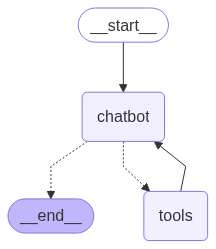

In [61]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 8. 실행

사용자 입력을 시뮬레이션하여 에이전트를 테스트할 수 있습니다. 이를 통해 도구와 워크플로가 예상대로 작동하는지 확인할 수 있습니다.

In [ ]:
import uuid

thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


User:  직원은 몇명인가


Assistant: 
===== INSIDE NL2SQL TOOL =====
Assistant: [(8,)]
Assistant: 직원 수는 8명입니다.


User:  아마존에서 개발한 촉각로봇의 이름은 무엇인가


Assistant: 
Assistant: [{"title": "아마존의 물류에는 로봇이 있다 : 네이버 블로그", "url": "https://blog.naver.com/thesouppub/223775479368", "content": "신고하기. ​. 아마존은 2012년 로봇 스타트업 기업,. 키바 시스템을 인수했습니다. 키바 시스템은 현재 아마존 로보틱스로 이름을 바꿨다. 전 세계 200여", "score": 0.7570233}, {"title": "[그게 뭔가요] 아마존이 만든 로봇 총정리 - 바이라인네트워크", "url": "https://byline.network/2023/11/1-1225/", "content": "바이라인네트워크\n바이라인네트워크\n\n# [그게 뭔가요] 아마존이 만든 로봇 총정리\n\n아마존이 만든 로봇을 모아봤습니다. 아마존이 로봇에 힘을 쓰는 데는 이유가 있습니다. 효율성과 안전성을 목표로 로봇을 물류센터에 바로 투입하기 위한 목적인데요. 로봇팔과 자율주행 로봇을 선보이더니 최근에는 이를 망라한 물류 로봇 시스템을 선보이기도 했죠. 가정 내에서 쓰는 로봇까지, 그 라인업을 다양화하고 있습니다. 아마존이 발표한 로봇에 어떤 것들이 있는지 살펴볼까요?\n\n스패로우\n\n아마존이 지난해 하반기 공개한 로봇 팔의 이름은 ‘스패로우’. 물류 창고 내 재고에서 주문이 들어온 개별 제품을 감지하고 선택, ‘토트’라고 하는 바구니로 옮기는 역할을 합니다. 로봇에 달린 카메라로 사물을 인식, 판별하도록 컴퓨터 비전 기술과 인공지능이 활용됩니다. 아마존에 따르면 스패로우는 현재 아마존 제품 재고의 65%를 식별할 수 있다고 하는데요. 상품 항목 수가 수백만 가지에 달하는 거죠. [...] YouTube video\nYouTube video\n\n위 영상을 보면 아시겠지만, 스패로우의 팔 끝에는 흡착판이 붙어 있어서 물건을 집어냅니다. 비타민 병에서부터 종이 포장으로 되어 있는 물건까지 분별하고 골라내지만 팔을 자유롭게 움직일 뿐, 로봇 자체가

User:  아마존에서 개발한 로봇의 이름을 문서에서 찾아줘


Assistant: 
=== RETRIEVER ===
Assistant: 정책･법제기업･산업기술･연구인력･교육
9
아마존, 촉각 기능을 갖춘 물류 로봇 ‘벌컨’ 공개n아마존이 처리 가능한 품목을 식별하는 알고리즘이 적용되고 물체의 크기와 모양에 따라 그립 강도를 조절할 수 있는 물류 로봇 ‘벌컨’을 공개n아마존은 미국과 독일의 물류센터에 벌컨을 도입해 직원의 육체적 부담을 줄이고 안전을 개선하고 있으며, 향후 몇 년간 유럽과 미국 전역의 물류센터에 벌컨을 도입할 계획
KEY Contents

KEY Contents
£벌컨, 물품에 접촉하는 지점과 압력을 인식해 좁은 공간에서 물품 이동 능력 제고n아마존(Amazon)이 2025년 5월 7일 로봇공학과 엔지니어링, 피지컬 AI 분야의 핵심 기술을 활용해 제작된 물류 로봇 ‘벌컨(Vulcan)’을 공개∙이전까지는 산업용 로봇에 예상치 않은 접촉이 있으면 비상 정지하거나 접촉을 아예 감지하지 못하는 경우가 일반적이었으나, 벌컨은 촉각 기능을 갖춘 최초의 로봇이라는 점에서 기존 로봇과 차별화∙벌컨에는 처리 가능한 품목과 불가능한 품목을 식별하는 알고리즘과 같은 피지컬 AI 기술이 적용되었으며, 수천 가지 물품을 다루는 실제 사례로 훈련을 진행n아마존 물류센터는 약 0.093제곱미터 크기의 칸에 최대 10개의 상품을 보관하는데, 좁은 공간에서 물품을 잡기가 어려운 기존 산업용 로봇과 달리, 벌컨은 로봇 팔 끝에 부착된 장치(EOAT*)를 통해 물품에 접촉하는 지점과 가해지는 압력을 인식해 손상 없이 물품을 이동 가능   * End of Arm Tooling: 벌컨의 EoAT는 물품을 밀어내는 장치와 집게, 압력 피드백 센서 등으로 구성∙벌컨에 탑재된 집게 장치는 압력 피드백 센서를 바탕으로 물체의 크기와 모양에 따라 그립 강도를 조절할 수 있으며, 카메라로 수납공간을 확인해 물체를 가장 잘 잡을 수 있는 위치를 파악∙벌컨은 물류센터에 보관되는 모든 종류의 품목 중 약 75%를 픽업하고 적재할 수 있고 물품 픽업이 불가능

User:  2024년 대선에서 당선된 미국의 대통령은 누구인가


Assistant: 
Assistant: [{"title": "2024년 미국 대통령 선거 - 위키백과, 우리 모두의 백과사전", "url": "https://ko.wikipedia.org/wiki/2024%EB%85%84_%EB%AF%B8%EA%B5%AD_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%84%A0%EA%B1%B0", "content": "2024년 미국 대통령 선거(영어: 2024 United States presidential election)는 2024년 11월 5일 화요일에 치러진 60번째 미국의 대통령 선거이다.[\\[3\\]]( 선거 결과 공화당 \"공화당 (미국)\")의 미국의 전 45대 대통령 도널드 트럼프 대통령 후보와 오하이오주 상원의원 JD 밴스 부통령 후보가 민주당 \"민주당 (미국)\")의 현 부통령 카멀라 해리스 대통령 후보와 미네소타주 주지사 팀 월즈 부통령 후보 측을 물리치고 선거에서 승리하였다.[\\[4\\]]( 선거에서 승리한 트럼프와 밴스는 선거인단에 의한 공식 인증 이후 2025년 1월 20일 제47대 대통령과 제50대 부통령으로 취임했다.[\\[6\\]]( [...] | 선거 결과 |\n| --- |\n| 대통령 후보 | 정당 | 기반주 | 득표[\\[376\\]]( | 선거인단[\\[2\\]]( | 러닝메이트 |\n| 총 득표수 | 비율 | 부통령 후보 | 기반주 |\n| 도널드 트럼프 | 공화당 \"공화당 (미국)\") | 플로리다주 | 77,302,169 | 49.74% | 312 | JD 밴스 | 오하이오주 |\n| 카멀라 해리스 | 민주당 \"민주당 (미국)\") | 캘리포니아주 | 75,015,834 | 48.27% | 226 | 팀 월즈 | 미네소타주 |\n| 질 스타인 | 녹색당 | 매사추세츠주 | 861,141 | 0.55% | 0 | 부치 웨어\") | 캘리포니아주 |\n| 로버트 F. 케네디 주니어[\\[o\\]]( | 무소속 | 캘리포니아주 | 756,377 | 0.49% | 